In [1]:
#include "TFile.h"
#include "TTree.h"
#include "TBrowser.h"
#include "TH1.h"
#include "TRandom.h"
#include "TCanvas.h"
#include "TMath.h"
#include "TROOT.h"
#include <string>
#include <iostream>
#include "TTreeReader.h"
#include <tuple>
#include <vector>
#include <utility>      // std::pair, std::make_pair
//#include "../test/Event.h"

In [2]:
//TDRStyle
gSystem->Load("style-CMSTDR.C");

In [3]:
int CreateRandomTree(std::string name){
    /*
    Create trees for tries   
    */
    gROOT->Reset();
    /*
    Create Ttrees for tries 
    */
    std::string Name = name+".root";
    //convierto en cadena de caracteres constante (es lo que recibe la función)
    const char * constName = Name.c_str();
    //const char * constname = name.c_str();
    TFile hfile(constName,"RECREATE");
    //The Ttrees must to have the same name "tree" in this case, "Delphes"
    TTree *T = new TTree("tree","test Ttree");
    Double_t px,py,pz;
    UShort_t i;
    T->Branch("px",&px,"px/D");
    T->Branch("py",&py,"py/D");
    T->Branch("pz",&pz,"pz/D");
    T->Branch("i",&i,"i/s");
    for (i = 0; i < 65000; i++) {
        px = (Double_t) gRandom->Binomial(500,0.05);
        pz = (Double_t) gRandom->Landau(-10,100);
        py = (Double_t) gRandom->Gaus(0,1000);
        T->Fill();
    }

    //T->Print();
    hfile.Write();
    hfile.Close();
   return 0;
}

In [4]:
void* TypeAllocate(std::string str){
    /*
    C : a character string terminated by the 0 character
    B : an 8 bit signed integer (Char_t)
    b : an 8 bit unsigned integer (UChar_t)
    S : a 16 bit signed integer (Short_t)
    s : a 16 bit unsigned integer (UShort_t)
    I : a 32 bit signed integer (Int_t)
    i : a 32 bit unsigned integer (UInt_t)
    F : a 32 bit floating point (Float_t)
    D : a 64 bit floating point (Double_t)
    L : a 64 bit signed integer (Long64_t)
    l : a 64 bit unsigned integer (ULong64_t)
    O : [the letter o, not a zero] a boolean (Bool_t)
    */ 
    if (str=="C") {
        char *ptr=new char;
        return (void*)ptr;
    }
    if (str=="B"){
        Char_t *ptr=new Char_t;
        return (void*)ptr;
    }
    if (str=="b"){
        UChar_t *ptr=new UChar_t;
        return (void*)ptr;
    }
    if (str=="S"){
        Short_t *ptr=new Short_t;
        return (void*)ptr;
    }
    if (str=="s"){
        UShort_t *ptr=new UShort_t;
        return (void*)ptr;
    }
    if (str=="I"){
        Int_t *ptr=new Int_t;
        return (void*)ptr;
    }
    if (str=="i"){
        UInt_t *ptr=new UInt_t;
        return (void*)ptr;
    }
    if (str=="F"){
        Float_t *ptr=new Float_t;
        return (void*)ptr;
    }
    if (str=="D"){
        Double_t *ptr=new Double_t;
        return (void*)ptr;
    }
    if (str=="L"){
        Long64_t *ptr=new Long64_t;
        return (void*)ptr;
    }
    if (str=="l"){
        ULong64_t *ptr=new ULong64_t;
        return (void*)ptr;
    }
    if (str=="O"){
        Bool_t *ptr=new Bool_t;
        return (void*)ptr;
    }
    return NULL;
}


In [5]:
//CreateRandomTree("tree1");
//CreateRandomTree("tree2");
//CreateRandomTree("tree3");
//CreateRandomTree("tree4");

In [6]:
TChain * chain1 = new TChain("tree","1");
TChain * chain2 = new TChain("tree","2");
chain1->Add("tree1.root");
chain1->Add("tree2.root");
chain2->Add("tree3.root");
chain2->Add("tree4.root");

In [7]:
std::map<std::string,TH1D *> Plotter(TChain * chain1, Bool_t Debug=0, std::vector<std::string> Branches={},Double_t Max=100.0, Double_t Min=0.0, Int_t NBines=100)
{
    std::map<std::string,TChain*> ChainMap;
    std::map<std::string,void*> ptrMap;
    std::map<std::string,TH1D *> HistoMap;
    std::vector<std::pair <std::string,std::string>> NamesArray;
    
    auto Array=chain1->GetListOfBranches();
    Int_t ArrayEntries=Array->GetEntries();
    for ( Int_t j=0 ; j<ArrayEntries ; j++ ){
        auto object = Array->At(j);
        std::string name = object->GetName();
        std::string nameplus = name+chain1->GetTitle();

        if(Debug){
            object->Print();
            std:cout<<"Name: "<<nameplus<<std::endl;
        }
        //See if name is in the list of the user
        if(!Branches.empty()){
            Bool_t flag=0;
            for (auto it: Branches){
                if(it==name)  flag=1;
            }
            if(!flag) continue;
        }
        //Getting the type of the branch
        std::string Title=object->GetTitle();
        std::size_t found=Title.find_last_of('/');
        if (found!=std::string::npos){
            std::string Type = Title.substr(found+1);
            //   Specify address where to read the event object
            if(Debug) std::cout<<"Type: "<<Type<<std::endl;
            //Aloco un puntero al tipo de dato del branch, y lo guardo en el map, con el key nombre
            ptrMap[name]=TypeAllocate(Type);
            if(Debug) std::cout<<"ptr: "<<ptrMap[name]<<std::endl;
            //El branch se va a leer de la dirección del puntero gurdado en el PointMap[name]
            chain1->SetBranchAddress(name.c_str(), ptrMap[name]);
            //   Create an histogram
            HistoMap[nameplus] = new TH1D(nameplus.c_str(),Title.c_str(),NBines,Min,Max);
            //Saving the names
            NamesArray.push_back(std::make_pair(name,nameplus));

        }
        else{
            std::cout<<"Error no type defined in "<<Title<<std::endl;
        }
    }
    
    
    //Filling the Histograms
    for (Int_t j=0;j<chain1->GetEntries();j++) {
        chain1->GetEvent(j);              //read complete accepted event in memory
        if(Debug) if(j==10) break;
        for (auto it:NamesArray){            
            HistoMap[it.second]->Fill(*((Double_t*)ptrMap[it.first]) /*, el peso va acá*/);  //Fill histogram with 
            if(Debug) {
                std::cout<<"Name: "<<it.second<<std::endl;
                std::cout<<"Pointer: "<<ptrMap[it.first]<<std::endl;
            }
        }                            //iterar sobre Sobre los branches del mapa              
    }
    
 return HistoMap;
}

In [8]:
mapa = Plotter(chain1)

(std::map<basic_string<char>, TH1D *, less<basic_string<char> >, allocator<pair<const basic_string<char>, TH1D *> > > &) { "i1" => @0x7fea54c6d590, "px1" => @0x7fea54cdd430, "py1" => @0x7fea54c6ca30, "pz1" => @0x7fea54c6d430 }


In [ ]:
//To ask for just a branch
std::vector<std::string> branches;
branches.push_back("px");
branches.push_back("py");

In [ ]:
auto mapa1 = Plotter(chain2,0,branches)

In [9]:
mapa["px1"]

(TH1D *) 0x7fea54c6b810


In [ ]:
//y = new TH1D("pp","Marica",100,0,1);
//pp->Print()

Entrego varias chains en un array.

In [ ]:
std::vector<TChain *> ChainVec;
ChainVec.push_back(chain1);
ChainVec.push_back(chain2);

In [ ]:
for (auto it=ChainVec.begin(); it!=ChainVec.end(); it++){

    std::cout<< "llamada al programa que crea los " <<std::endl;

}

In [ ]:
a=mapa["px"]

In [ ]:
a

In [11]:
THStack *hs = new THStack();

In [12]:
hs->Add(mapa["px1"]);
hs->Add(mapa["py1"]);
hs->Add(mapa["pz1"]);

In [13]:
TCanvas *cst = new TCanvas();
cst->Divide(2,2);

In [14]:
cst->cd(1);
hs->Draw();

In [15]:
cst->cd(2);
gPad->SetGrid();
hs->Draw("nostack,e1p");

In [16]:
cst->cd(3);
gPad->SetFrameFillColor(17);
gPad->SetTheta(3.77);
gPad->SetPhi(2.9);
hs->Draw("lego1");

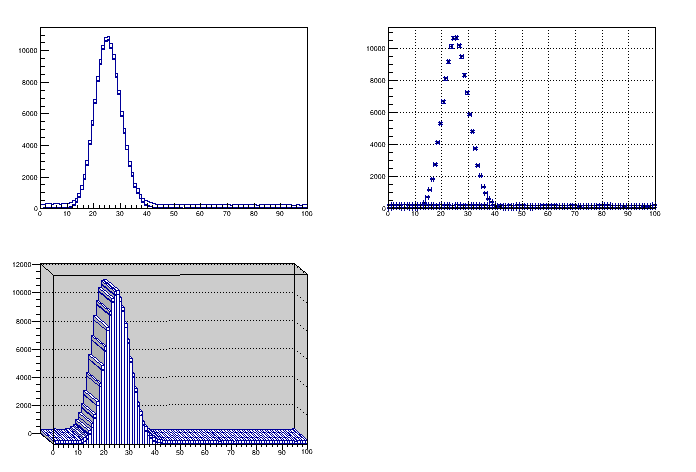

In [17]:
gROOT->GetListOfCanvases()->Draw()

Hay una propiedad de los plots que es integrate, y se puede normalizar sobre eso, Ver el codigo de Jose (Nelson)    TemHisto1.Scale(1./TemHisto1.Integral())

In [ ]:
//mapa["px"]->GetEntries()

Double_t Max=100.0;
Double_t Min=0.0;
Int_t NBines=100;
Bool_t Debug=1;
std::map<std::string,TChain*> ChainMap;
std::map<std::string,void*> ptrMap;
std::map<std::string,TH1D *> HistoMap;
std::vector<std::string> NamesArray;
auto Array=chain1->GetListOfBranches();
Int_t ArrayEntries=Array->GetEntries();
for ( Int_t j=0 ; j<ArrayEntries ; j++ ){
    auto object = Array->At(j);
    std::string name=object->GetName();
    if(Debug){
        object->Print();
        std:cout<<"Name: "<<name<<std::endl;
    }
    //Getting the type of the branch
    std::string Title=object->GetTitle();
    std::size_t found=Title.find_last_of('/');
    if (found!=std::string::npos){
        std::string Type = Title.substr(found+1);
        //   Specify address where to read the event object
        if(Debug) std::cout<<"Type: "<<Type<<std::endl;
        //Aloco un puntero al tipo de dato del branch, y lo guardo en el map, con el key nombre
        ptrMap[name]=TypeAllocate(Type);
        if(Debug) std::cout<<"ptr: "<<ptrMap[name]<<std::endl;
        //El branch se va a leer de la dirección del puntero gurdado en el PointMap[name]
        chain1->SetBranchAddress(name.c_str(), ptrMap[name]);
        //   Create an histogram
        HistoMap[name] = new TH1D(name.c_str(),Title.c_str(),NBines,Min,Max);
        //Saving the names
        NamesArray.push_back(name);
    }
    else{
        std::cout<<"Error no type defined in "<<Title<<std::endl;
    }
    
}

//Filling the Histograms
for (Int_t j=0;j<chain1->GetEntries();j++) {
        chain1->GetEvent(j);              //read complete accepted event in memory
        if(Debug) if(j==10) break;
        for (auto it=NamesArray.begin(); it!=NamesArray.end(); it++){            
            HistoMap[*it]->Fill(*((Double_t*)ptrMap["pz"]) /*, el peso va acá*/);  //Fill histogram with 
            if(Debug) {
                std::cout<<"Name: "<<*it<<std::endl;
                std::cout<<"Pointer: "<<ptrMap[*it]<<std::endl;
            }
        }                            //iterar sobre Sobre los branches del mapa
                  
    }